Projet
===

- Johan PLANCHON
- Julien CAPOSIENA

## 1. Collecte de données

1) Créer un dossier appelé `images`

In [1]:
import os

if not os.path.exists('images'):
    os.mkdir('images')

2) Télécharger les images sous licence ouverte dans le dossier images (minimum 100 images).

In [2]:
%pip install sparqlwrapper

Note: you may need to restart the kernel to use updated packages.


On va récupérer 100 langages de programmation et leur logo

In [3]:
import sys
import pandas as pd
from SPARQLWrapper import SPARQLWrapper, JSON

endpoint_url = "https://query.wikidata.org/sparql"

query = """
SELECT DISTINCT ?catBreed ?catBreedLabel ?image {
    ?catBreed wdt:P31 wd:Q43577;
        wdt:P18 ?image.
    SERVICE wikibase:label { bd:serviceParam wikibase:language "fr,en". }
}
LIMIT 100
"""


def get_results(endpoint_url, query):
    user_agent = "WDQS-example Python/%s.%s" % (
        sys.version_info[0],
        sys.version_info[1],
    )
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()


array = []
results = get_results(endpoint_url, query)

for result in results["results"]["bindings"]:
    array.append(
        (
            result["catBreedLabel"]["value"],
            result["image"]["value"],
        )
    )

In [4]:
dataframe = pd.DataFrame(array, columns=["catBreed", "image"])
dataframe = dataframe.astype(
    dtype={"catBreed": "<U200", "image": "<U200"}
)
dataframe

,catBreed,image
0,Lykoi,http://commons.wikimedia.org/wiki/Special:File...
1,Modern Siamese,http://commons.wikimedia.org/wiki/Special:File...
2,Suphalak,http://commons.wikimedia.org/wiki/Special:File...
3,Suphalak,http://commons.wikimedia.org/wiki/Special:File...
4,Suphalak,http://commons.wikimedia.org/wiki/Special:File...
...,...,...
95,Angora turc,http://commons.wikimedia.org/wiki/Special:File...
96,Mau égyptien,http://commons.wikimedia.org/wiki/Special:File...
97,Serengeti,http://commons.wikimedia.org/wiki/Special:File...
98,Bobtail américain,http://commons.wikimedia.org/wiki/Special:File...


On télécharge les images dans le dossier `images`

In [5]:
import requests
import shutil
from os.path import join, basename

def download_image(url):
    headers = {"User-Agent": "Mozilla/5.0"}
    request = requests.get(url, allow_redirects=True, headers=headers, stream=True)
    if request.status_code == 200:
        with open(join('images', basename(url)), "wb") as image:
            request.raw.decode_content = True
            shutil.copyfileobj(request.raw, image)
    return request.status_code

In [6]:
dataframe.image.apply(download_image)

0     200
1     200
2     200
3     200
4     200
     ... 
95    200
96    200
97    200
98    200
99    200
Name: image, Length: 100, dtype: int64

3) On enregistre les métadonnées de chaque image comme la taille de l'image, le format de l'image (.jpeg, .png, etc.), l'orientation de l'image (paysage, portrait, carré, etc.), date de création, modèle d'appareil photo, etc. dans un ou plusieurs fichiers JSON. Vous pouvez utiliser les informations Exif présentes dans les fichiers d'images.

In [7]:
import mimetypes as mt
import pandas as pd
from PIL import Image
from PIL import TiffImagePlugin
from PIL.ExifTags import TAGS
from os.path import join

def get_metadata():
    metadata = dict()
    headers = ["Extension"]

    for filename in os.listdir('images'):
        if filename.endswith('.svg'):
            continue

        image = Image.open(join('images/', filename))
        exif_data = image.getexif()

        exif = {}
        exif["Extension"] = mt.guess_type(join("images/", filename))[0]

        if exif_data:  # s'il existe des informations EXIF
            for tag, value in exif_data.items():
                if tag in TAGS:
                    if isinstance(value, TiffImagePlugin.IFDRational):
                        exif[TAGS[tag]] = float(value)
                    elif isinstance(value, tuple):
                        exif[TAGS[tag]] = tuple(float(t) if isinstance(t, TiffImagePlugin.IFDRational) else t for t in value)
                    elif isinstance(value, bytes):
                        exif[TAGS[tag]] = value.decode(errors="replace")
                    else:
                        exif[TAGS[tag]] = value

                    if TAGS[tag] not in headers:
                        headers.append(TAGS[tag])

        metadata[filename] = exif

    return metadata, headers


metadata, headers = get_metadata()

framed_metadata = pd.DataFrame.from_dict(metadata, orient='index', columns=headers)
for data in framed_metadata:
    for header in headers:
        framed_metadata.loc[framed_metadata[header].isna(), [header]] = "No " + header

framed_metadata

,Extension,ResolutionUnit,ExifOffset,ImageDescription,Make,Model,Software,DateTime,YResolution,Copyright,...,WhiteBalance,SceneCaptureType,Sharpness,SubjectDistanceRange,HostComputer,TileWidth,TileLength,Compression,StripOffsets,PlanarConfiguration
Balinais.jpg,image/jpeg,2.0,282.0,www.heikkisiltala.com,Canon,Canon EOS 40D,GIMP 2.8.10,2015:01:12 15:27:01,240.0,Copyright Heikki Siltala 2008,...,No WhiteBalance,No SceneCaptureType,No Sharpness,No SubjectDistanceRange,No HostComputer,No TileWidth,No TileLength,No Compression,No StripOffsets,No PlanarConfiguration
European-cat%20show%20Helsinki%202008.JPG,image/jpeg,2.0,321.0,www.heikkisiltala.com,Canon,Canon EOS 40D,Custom Workflow,2008:04:27 11:27:13,72.0,Copyright Heikki Siltala 2008,...,No WhiteBalance,No SceneCaptureType,No Sharpness,No SubjectDistanceRange,No HostComputer,No TileWidth,No TileLength,No Compression,No StripOffsets,No PlanarConfiguration
Serengetimalecat.jpg,image/jpeg,No ResolutionUnit,No ExifOffset,No ImageDescription,No Make,No Model,No Software,No DateTime,No YResolution,No Copyright,...,No WhiteBalance,No SceneCaptureType,No Sharpness,No SubjectDistanceRange,No HostComputer,No TileWidth,No TileLength,No Compression,No StripOffsets,No PlanarConfiguration
Munchkin%20cat%202.jpg,image/jpeg,No ResolutionUnit,89.0,No ImageDescription,Canon,Canon EOS 6D,No Software,No DateTime,No YResolution,No Copyright,...,No WhiteBalance,No SceneCaptureType,No Sharpness,No SubjectDistanceRange,No HostComputer,No TileWidth,No TileLength,No Compression,No StripOffsets,No PlanarConfiguration
Bombay%20Katze%20Ebene%20of%20Blue%20Sinfonie.JPG,image/jpeg,2.0,360.0,No ImageDescription,Canon,Canon EOS 500D,No Software,2009:08:06 15:07:27,72.0,,...,No WhiteBalance,No SceneCaptureType,No Sharpness,No SubjectDistanceRange,No HostComputer,No TileWidth,No TileLength,No Compression,No StripOffsets,No PlanarConfiguration
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
JapaneseBobtailBlueEyedMi-ke.JPG,image/jpeg,2.0,148.0,No ImageDescription,FUJIFILM,FinePix F810,Digital Photo Professional,2007:04:03 17:45:17,350.0,,...,No WhiteBalance,No SceneCaptureType,No Sharpness,No SubjectDistanceRange,No HostComputer,No TileWidth,No TileLength,No Compression,No StripOffsets,No PlanarConfiguration
Bicolor%20Persian.jpg,image/jpeg,2.0,266.0,No ImageDescription,NIKON CORPORATION,NIKON D90,QuickTime 7.6.2,2009:08:18 16:40:48,72.0,No Copyright,...,No WhiteBalance,No SceneCaptureType,No Sharpness,No SubjectDistanceRange,Mac OS X 10.5.7,No TileWidth,No TileLength,No Compression,No StripOffsets,No PlanarConfiguration
Cruel.JPG,image/jpeg,2.0,556.0,OLYMPUS DIGITAL CAMERA,OLYMPUS_IMAGING_CORP.,"X450,D535Z,C370Z",Adobe Photoshop 7.0,2006:04:15 23:09:39,200.0,No Copyright,...,No WhiteBalance,No SceneCaptureType,No Sharpness,No SubjectDistanceRange,No HostComputer,No TileWidth,No TileLength,No Compression,No StripOffsets,No PlanarConfiguration
Aegean%20Island%20Cat.jpg,image/jpeg,2.0,2306.0,No ImageDescription,No Make,No Model,Windows Photo Editor 10.0.10011.16384,2021:03:29 13:03:08,72.0,No Copyright,...,No WhiteBalance,No SceneCaptureType,No Sharpness,No SubjectDistanceRange,No HostComputer,No TileWidth,No TileLength,No Compression,No StripOffsets,No PlanarConfiguration


In [8]:
with open('metadata.json', 'w') as f:
    f.write(framed_metadata.to_json(orient='index'))

## Étiquetage et annotation

Pour cette tâche, vous devez rechercher les sources disposant d'informations supplémentaires comme les balises, les catégories, etc.
Premièrement on créé une fonction pour transformer un tuple RGB en couleur humaine (ex (255, 0, 0) -> Red)

In [9]:
from scipy.spatial import KDTree
from webcolors import (
    CSS3_HEX_TO_NAMES,
    CSS3_NAMES_TO_HEX,
    hex_to_rgb,
)

def convert_rgb_to_names(rgb_tuple):
    css3_db = CSS3_HEX_TO_NAMES
    names = []
    rgb_values = []
    for color_hex, color_name in css3_db.items():
        names.append(color_name)
        rgb_values.append(hex_to_rgb(color_hex))

    kdt_db = KDTree(rgb_values)
    distance, index = kdt_db.query(rgb_tuple)
    return names[index]

Ensuite on créé une fonction pour récupérer les 2 couleurs les plus présentes dans l'image passée en paramètres

In [10]:
from PIL import Image
import numpy as np
import math
from sklearn.cluster import KMeans

def get_most_seen_colors(file_path):
    img_file = Image.open(file_path).convert("RGBA")

    nb_colors = 2
    clusters = KMeans(n_clusters=nb_colors, n_init=2)

    numarray = np.array(img_file.getdata(), np.uint8)
    clusters.fit(numarray)

    np.arange(0, nb_colors + 1)

    most_seen_colors = []
    for i in range(nb_colors):
        most_seen_colors.append(
            (
                math.ceil(clusters.cluster_centers_[i][0]),
                math.ceil(clusters.cluster_centers_[i][1]),
                math.ceil(clusters.cluster_centers_[i][2]),
            )
        )

    return most_seen_colors

On ajoute les 2 couleurs les plus présentes dans chaque image en tant que tag dans le fichier `metadata.json`

In [11]:
import json

with open('metadata.json', 'r') as metadata_file:
    metadata = json.load(metadata_file)

    for image in metadata:
        most_seen_colors = get_most_seen_colors('images/' + image)

        for index, color in enumerate(most_seen_colors):
            metadata[image]["Color" + str(index + 1)] = convert_rgb_to_names(color)

In [12]:
with open('metadata.json', 'w') as metadata_file:
    json.dump(metadata, metadata_file)

On ajoute un tag à toutes les images avec l'input utilisateur

In [13]:
import json

with open('metadata.json', 'r') as metadata_file:
    metadata = json.load(metadata_file)

    tag = input('Ajouter un tag aux images: ')

    for image in metadata:
        metadata[image][tag] = False

with open('metadata.json', 'w') as metadata_file:
    json.dump(metadata, metadata_file)
    metadata_file.close()

## Analyses de données

On attribue `y` images likées à `i` utilisateurs (sans doublon)

In [14]:
seed = 1312

In [30]:
import random, os

nb_users = 5
nb_images_likes = 20
images = os.listdir('images')
nb_files = len(images)
users = []

for i in range(nb_users):
    users.append({ 'liked_images': [] })

    for y in range(nb_images_likes):
        liked_image = random.randrange(0, nb_files)

        if liked_image not in users[i]:
            users[i]['liked_images'].append(images[liked_image])

with open('users.json', 'w') as users_file:
    json.dump(users, users_file)
    users_file.close()

users

[{'liked_images': ['Cat-MaineCoon-Lucy.png',
   'Ocicat-sitting.jpg',
   'Manx%20cat%20by%20Karen%20Weaver.jpg',
   'Birman%20red%20lynx%20point%2002.jpg',
   'Turkse%20angora.jpg',
   'Lazuli01.jpg',
   'Bluebell%202ans.jpg',
   'Raffles%20singapura%20cat.jpg',
   'SuphalakKitten.jpg',
   'Balinais.jpg',
   'Siam%20lilacpoint.jpg',
   '%D0%A1%D0%BE%D0%BC%D0%B0%D0%BB%D0%B8%D0%B9%D1%81%D0%BA%D0%B0%D1%8F%20%D0%BA%D0%BE%D1%88%D0%BA%D0%B0.jpg',
   'SuphalakAyodia.jpg',
   'Squitten2.jpg',
   'American%20curl%202.jpg',
   'Paintedcats%20Red%20Star%20standing.jpg',
   'Himalayan%20cat%20percy.jpg',
   'Dragon%20Li%20-%20Li%20Hua%20Mau1.jpg',
   'Burmakatze-rot.jpg',
   'Gato%20pelo%20curto%20brasileiro.JPG']},
 {'liked_images': ['Seal%20Point%20Siamese%20Kitten.JPG',
   'Colorpoint%20Shorthair.jpg',
   'Beauxyeux.JPG',
   'NevaMasqueradeFiona%20%28cropped%29.jpg',
   'Orientalshorthairs2.jpg',
   'Nebelung%20Male%2C%20Aleksandr%20van%20Song%20de%20Chine.JPG',
   'Pantanal%20Pixie-Bob%202.jpg

Ensuite on test des images pour savoir si nos 5 utilisateurs vont aimer les images.
On a dû ajuster les données car si les champs `XResolution` et `YResolution` étaient vide ils contenaient `"No XResoolution"` au lieu de `0.0`

In [16]:
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn import tree
import pandas as pd
import math

def will_user_like_given_image(user, image_to_test):
    images = []
    result = []
    for image in metadata:
        if image in user['liked_images']:
            result.append("Favorite")
        else:
            result.append("Not favorite")
        images.append(metadata[image])

    dataframe = pd.DataFrame(images, columns=["Color1", "Color2", "XResolution", "YResolution", "DateTime"])
    resultframe = pd.DataFrame(result, columns=["Favorite"])

    le1 = LabelEncoder()
    dataframe["Color1"] = le1.fit_transform(dataframe["Color1"])

    le2 = LabelEncoder()
    dataframe["Color2"] = le2.fit_transform(dataframe["Color2"])

    le3 = LabelEncoder()
    dataframe["XResolution"] = le3.fit_transform(dataframe["XResolution"])

    le4 = LabelEncoder()
    dataframe["YResolution"] = le4.fit_transform(dataframe["YResolution"])

    le5 = LabelEncoder()
    dataframe["DateTime"] = le5.fit_transform(dataframe["DateTime"])


    le6 = LabelEncoder()
    resultframe["Favorite"] = le6.fit_transform(resultframe["Favorite"])

    dtc = tree.DecisionTreeClassifier(random_state=seed)
    dtc = dtc.fit(dataframe.values, resultframe)

    # prediction
    prediction = dtc.predict(
        [
            [
                le1.transform([image_to_test["Color1"]])[0],
                le2.transform([image_to_test["Color2"]])[0],
                le3.transform([image_to_test["XResolution"]])[0],
                le4.transform([image_to_test["YResolution"]])[0],
                le5.transform([image_to_test["DateTime"]])[0],
            ]
        ]
    )

    print(le6.inverse_transform(prediction)[0])
    print(dtc.feature_importances_)

In [21]:
import json

image_to_test = metadata["Bluebell%202ans.jpg"]
metadata = json.load(open('metadata.json'))

for user in users:
    will_user_like_given_image(user, image_to_test)

TypeError: Encoders require their input to be uniformly strings or numbers. Got ['float', 'str']

# Affichage des données

In [22]:
from webcolors import (
    CSS3_NAMES_TO_HEX,
)

def convert_name_to_hex(rgb_name):
    css3_db = CSS3_NAMES_TO_HEX
    rgb_names = []
    rgb_values = []
    for color_name, color_hex in css3_db.items():
        rgb_names.append(color_name)
        rgb_values.append(color_hex)

    index = rgb_names.index(rgb_name)
    return rgb_values[index]

In [23]:
def get_favorite_count_for_image(users):
    counts = dict()
    for user in users:
        for image in user['liked_images']:
            image_count = counts.get(image)
            if image_count:
                counts[image] = image_count + 1
            else:
                counts[image] = 1

    return lambda image: counts[image] if counts.get(image) else 0

In [24]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd

def get_dataframe(metadata, users):
    get_favorite_count = get_favorite_count_for_image(users)
    images = []
    for image in metadata:
        image_with_name = metadata[image]
        image_with_name["Name"] = image
        images.append(image_with_name)

    dataframe = pd.DataFrame(images, columns=["Name", "Color1", "Color2", "XResolution", "YResolution"])
    dataframe['FavoritedCount'] = dataframe["Name"].transform(get_favorite_count)

    return dataframe

In [25]:
import matplotlib.pyplot as plot

def get_plot_for_color(df, color, label):
    labels = df[color]
    plot.figure(figsize=(10, 3))  # width:20, height:3
    plot.xticks(range(len(labels)), labels, rotation='vertical')
    plot.title(label)
    barlist = plot.bar(range(len(labels)), df["ColorCount"], width=0.3, align='edge')
    idxable_labels = labels.reset_index()[color]
    for color_idx in range(0, len(labels)):
        barlist[color_idx].set_color(convert_name_to_hex(idxable_labels[color_idx]))

    return barlist

def get_color_plot_for_df(df, color, label):
    grouped = df.groupby(color).count()
    grouped = grouped.rename(columns={"Name": "ColorCount"})
    df = grouped["ColorCount"].reset_index()
    df = df.sort_values("ColorCount", ascending=False)

    return get_plot_for_color(df, color, label)
    

In [26]:
import json
metadata = json.load(open('metadata.json'))
users = json.load(open('users.json'))

df = get_dataframe(metadata, users)
df["Color1RGB"] = df["Color1"].transform(convert_name_to_hex)
df["Color2RGB"] = df["Color2"].transform(convert_name_to_hex)

<BarContainer object of 21 artists>

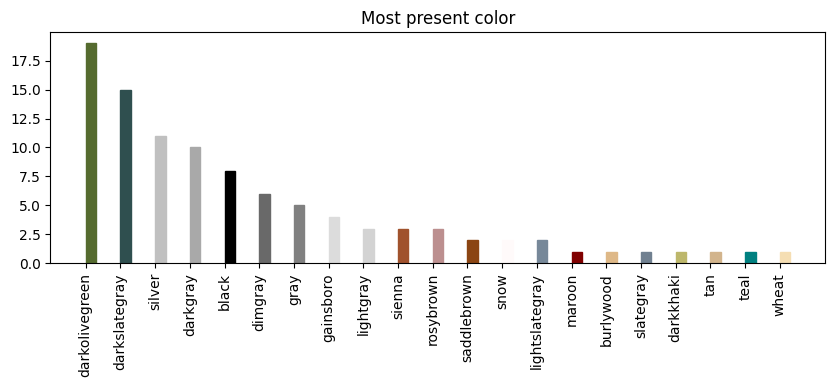

In [27]:
get_color_plot_for_df(df, "Color1", "Most present color")

<BarContainer object of 19 artists>

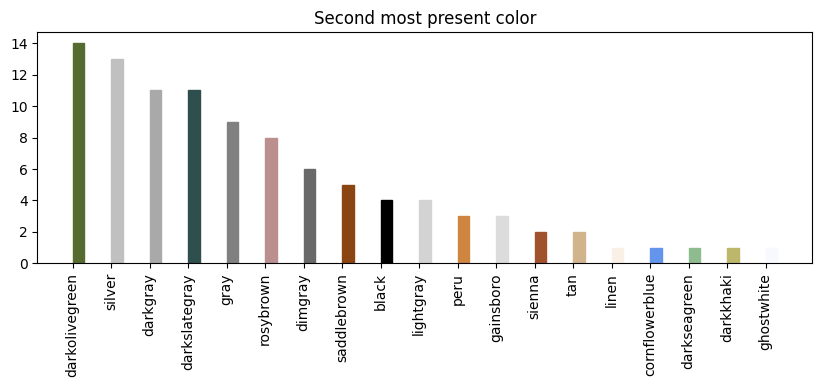

In [28]:
get_color_plot_for_df(df, "Color2", "Second most present color")

<BarContainer object of 21 artists>

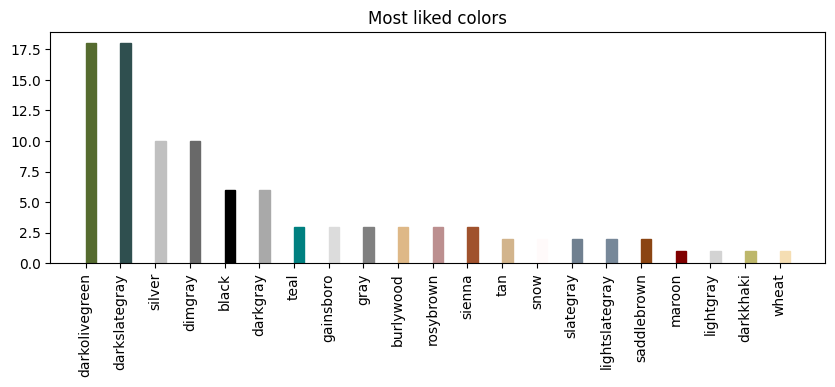

In [29]:
favorite_df = df.groupby(["Color1"])["FavoritedCount"].sum()
favorite_df = favorite_df.reset_index()
favorite_df = favorite_df.rename(columns={"FavoritedCount": "ColorCount"})
favorite_df = favorite_df.sort_values("ColorCount", ascending=False)
get_plot_for_color(favorite_df, "Color1", "Most liked colors")